# Data Mining and Big Data Analytics 
### Instructor: Márton Karsai, Associate Professor

### References:
* **scikit-learn tutorial** at [SciPy 2017](https://github.com/amueller/scipy-2017-sklearn) by [Alexandre Gramfort](http://http://alexandre.gramfort.net/)  [@agramfort](https://twitter.com/agramfort) (Inria, Université Paris-Saclay) and [Andreas Mueller](http://amuller.github.io) [@amuellerml](https://twitter.com/amuellerml) (Columbia University). See the book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) for more details. 
* **Data Mining, Statistical Modeling and Machine Learning** class by Dr. Ciro Cattuto, Dr. Laetitia Gauvin, Dr. André Panisson (ISI Foundation, Turi, Italy)

#### Install requires python libraries

We use pip but the same works for "conda".

>pip install scipy

>pip install pandas

>pip install scikit-learn

optional: 

>pip install seaborn

Mac users: please try installing graphviz using homebrew instead of anaconda

We are going to need a lot of Python packages, so let's start by importing all of them.

In [2]:
# Import the libraries we will be using

import os
import numpy as np
import matplotlib.pylab as plt
import graphviz 
import sklearn

%matplotlib inline

from IPython.display import set_matplotlib_formats
from IPython.display import Image

set_matplotlib_formats('retina')

C:\Users\molda\AppData\Local\Temp/ipykernel_7104/3843637724.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


We are also going to do a lot of repetitive stuff, so let's predefine some useful functions.

In [3]:
# A function that gives a visual representation of the decision tree

def show_decision_tree(model):
    dot_data = tree.export_graphviz(model, out_file=None) 
    graph = graphviz.Source(dot_data) 
#     To save on a PDF file
#     graph.render("iris")
    return graph

Import the iris dataset

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()

X, y = iris.data, iris.target

In [5]:
print(iris.keys())
print(iris.target_names)
print(iris.feature_names)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Useful features
Let's take a look at one of our features -- `"petal length (cm)"`. Is this feature useful? Let's plot the possible values of `"petal_length"` and color code our target variable.

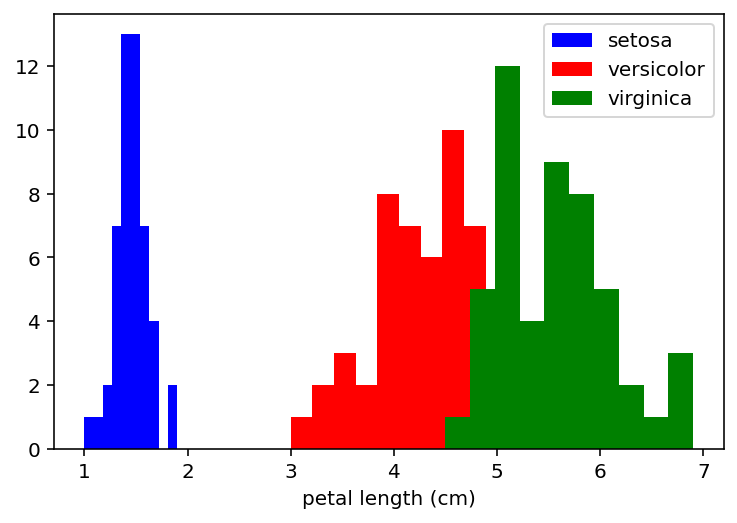

In [6]:
feature_index = iris.feature_names.index('petal length (cm)')
colors = ['blue', 'red', 'green']

for label, color in zip(range(len(iris.target_names)), colors):
    plt.hist(iris.data[iris.target==label, feature_index], 
             label=iris.target_names[label],
             color=color)
plt.xlabel(iris.feature_names[feature_index])
plt.legend(loc='upper right')
plt.show()

Is `"petal_length"` actually useful? Let's quantify it.

**Entropy** ($H$) and **information gain** ($IG$) are crucial in determining which features are the most informative. Given the data, it is fairly straight forward to calculate both of these.

<table style="border: 0px">
<tr style="border: 0px;background:'white'"">
<td style="border: 0px;background:'white'""><img src="images/dsfb_0304.png" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="images/dsfb_0305.png" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

In [7]:
def entropy(target):
    '''
    Formula: entropy = -p1*log(p1) - p2*log(p2) - ...
    '''
    # Get the number of users
    n = len(target)
    # Count how frequently each unique value occurs
    un,counts=np.unique(target,return_counts=True)
    # Initialize entropy
    entropy = 0
    # If the split is perfect, return 0
    if len(counts) <= 1 or 0 in counts:
        return entropy
    # Otherwise, for each possible value, update entropy
    for count in counts:
        entropy += math.log(float(count)/n, len(counts)) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, target, threshold):
    '''
    Formula: IG(parent,children) = entropy(parent) - [p(c1) * entropy(c1) + p(c2) * entropy(c2) + ...]
    '''
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

Now that we have a way of calculating $H$ and $IG$, let's pick a threshold, split `"petal_length"`, and calculate $IG$.

In [8]:
print(X[:,2])
print(y)


[1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 1.5 1.6 1.4 1.1 1.2 1.5 1.3 1.4
 1.7 1.5 1.7 1.5 1.  1.7 1.9 1.6 1.6 1.5 1.4 1.6 1.6 1.5 1.5 1.4 1.5 1.2
 1.3 1.4 1.3 1.5 1.3 1.3 1.3 1.6 1.9 1.4 1.6 1.4 1.5 1.4 4.7 4.5 4.9 4.
 4.6 4.5 4.7 3.3 4.6 3.9 3.5 4.2 4.  4.7 3.6 4.4 4.5 4.1 4.5 3.9 4.8 4.
 4.9 4.7 4.3 4.4 4.8 5.  4.5 3.5 3.8 3.7 3.9 5.1 4.5 4.5 4.7 4.4 4.1 4.
 4.4 4.6 4.  3.3 4.2 4.2 4.2 4.3 3.  4.1 6.  5.1 5.9 5.6 5.8 6.6 4.5 6.3
 5.8 6.1 5.1 5.3 5.5 5.  5.1 5.3 5.5 6.7 6.9 5.  5.7 4.9 6.7 4.9 5.7 6.
 4.8 4.9 5.6 5.8 6.1 6.4 5.6 5.1 5.6 6.1 5.6 5.5 4.8 5.4 5.6 5.1 5.1 5.9
 5.7 5.2 5.  5.2 5.4 5.1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [9]:
import math

threshold = 4.7
print("IG = %.4f with a thresholding of %.2f" %(information_gain(X[:, 2], y,threshold), threshold))

IG = 0.3215 with a thresholding of 4.70


To be more precise, we can iterate through all values and find the best split.

In [10]:
def best_threshold(X, y):
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X:
        ig = information_gain(X, y, threshold)
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print(best_threshold(X[:, 2], y))

The maximum IG = 0.520 and it occured by splitting on 1.9000.


Let's see how we can do this with just sklearn!

In [11]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=1, criterion="gini")
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

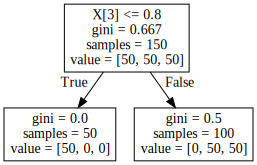

In [12]:
show_decision_tree(decision_tree)

If we use this as our decision tree, how accurate is it?

In [13]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 0.667


Let's add one more level to our decision tree.

In [14]:
decision_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
decision_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

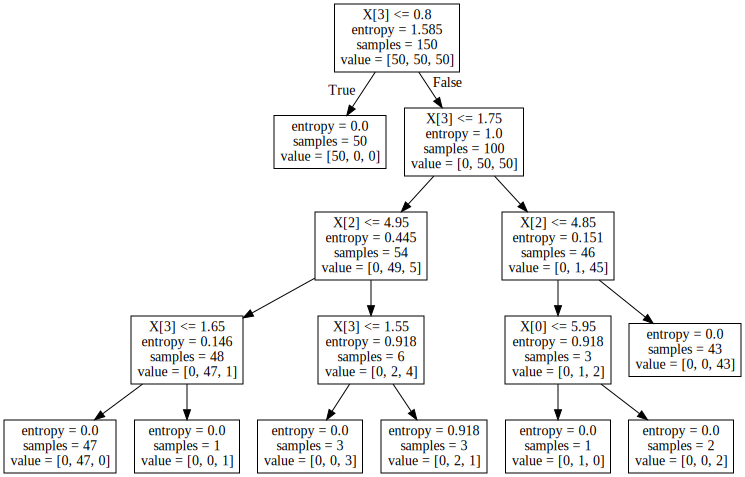

In [15]:
show_decision_tree(decision_tree)

In [16]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 0.993


# Exercise
1. Compare the best thresholds for different attributes.
2. Take 2/3 of rows to create a training dataset, and the rest for the test. Redo the decision tree and calculate the accuracy for the training set and test set. Do you get the same decision tree as with using the whole dataset?
3. Plot how accuracy varies with increaing values of the `max_depth` parameter. 
4. Starting from the function `best_threshold`, create a function that returns the IG for different thredholds, not simply the best one. Plot IG vs the threshold. This is always a good practice to understand how good your best threshold is.

# Solution

1. Compare the best thresholds for different attributes.

In [17]:
for a in range(0,4): 
    print("For", iris.feature_names[a],":", best_threshold(X[:, a], y))

For sepal length (cm) : The maximum IG = 0.352 and it occured by splitting on 5.6000.
For sepal width (cm) : The maximum IG = 0.179 and it occured by splitting on 3.4000.
For petal length (cm) : The maximum IG = 0.520 and it occured by splitting on 1.9000.
For petal width (cm) : The maximum IG = 0.545 and it occured by splitting on 0.6000.


2. Take 2/3 of rows to create a training dataset, and the rest for the test. Redo the decision tree and calculate the accuracy for the training set and test set. Do you get the same decision tree as with using the whole dataset?

In [19]:
import pandas as pd
df=pd.DataFrame(iris.target, columns={"Type"})
df["Type"].replace({0: iris.target_names[0], 1: iris.target_names[1], 2: iris.target_names[2]}, inplace=True)
df

,Type
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


In [20]:
df1 = pd.DataFrame(iris.data, columns=iris.feature_names)


In [21]:
df1.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [22]:
df2 = pd.concat([df, df1], axis=1)

In [23]:
df2

,Type,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,virginica,6.7,3.0,5.2,2.3
146,virginica,6.3,2.5,5.0,1.9
147,virginica,6.5,3.0,5.2,2.0
148,virginica,6.2,3.4,5.4,2.3


In [24]:
train = df2.sample(frac=2/3, random_state=25)
test = df2.drop(train.index)

In [25]:
train.count()

Type                 100
sepal length (cm)    100
sepal width (cm)     100
petal length (cm)    100
petal width (cm)     100
dtype: int64

In [26]:
test.count()

Type                 50
sepal length (cm)    50
sepal width (cm)     50
petal length (cm)    50
petal width (cm)     50
dtype: int64

Just checking if df is the same:

<AxesSubplot:xlabel='petal width (cm)', ylabel='Count'>

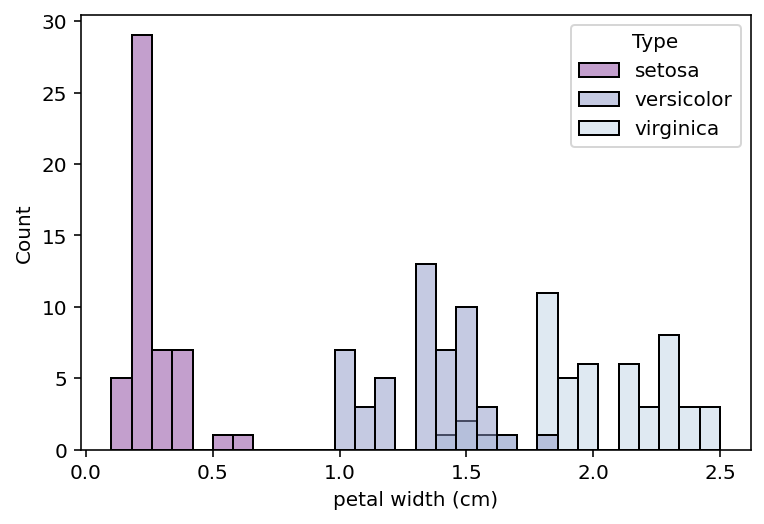

In [27]:
import seaborn as sns
sns.histplot(x='petal width (cm)', hue='Type', bins=30, data=df2, palette='BuPu_r')

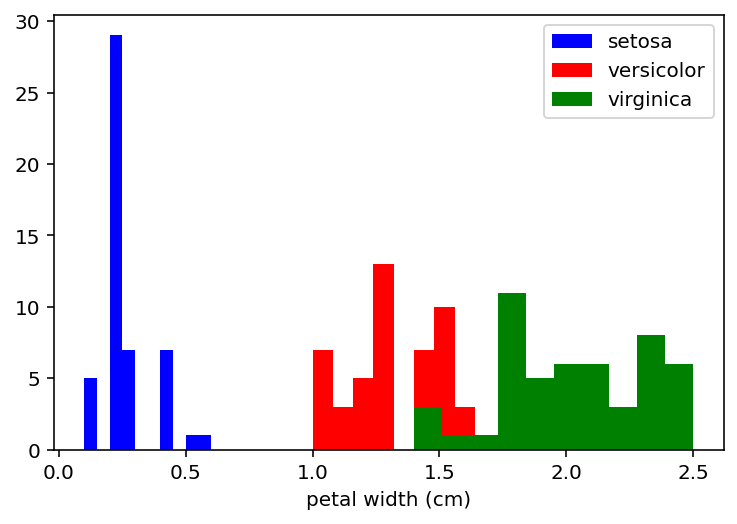

In [28]:
x_index = 3 # Petal width (cm)
colors = ['blue', 'red', 'green']

for label, color in zip(range(len(iris.target_names)), colors):
    plt.hist(iris.data[iris.target==label, x_index], 
             label=iris.target_names[label],
             color=color)

plt.xlabel(iris.feature_names[x_index])
plt.legend(loc='upper right')
plt.show()

In [29]:
X = train.drop('Type',axis=1)
y = train['Type']

In [30]:
decision_tree = DecisionTreeClassifier(max_depth=1, criterion="gini")
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

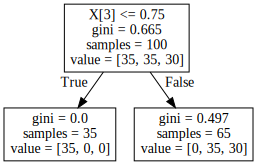

In [31]:
show_decision_tree(decision_tree)

In [32]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 0.700


In [33]:
decision_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
decision_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

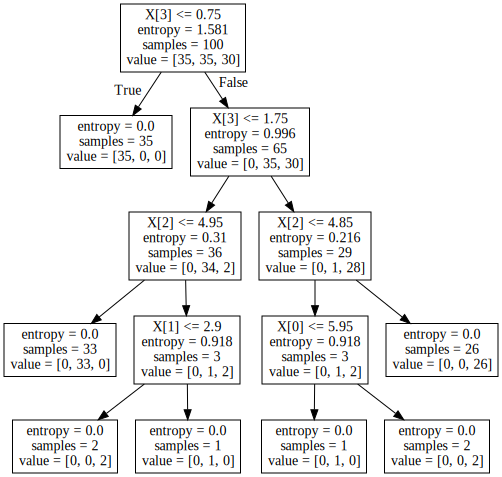

In [34]:
show_decision_tree(decision_tree)

In [35]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 1.000


Now the same for the test:

In [36]:
X = test.drop('Type',axis=1)
y = test['Type']

In [37]:
decision_tree = DecisionTreeClassifier(max_depth=1, criterion="gini")
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

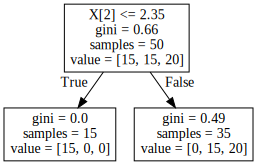

In [38]:
show_decision_tree(decision_tree)

In [39]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 0.700


In [40]:
decision_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
decision_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

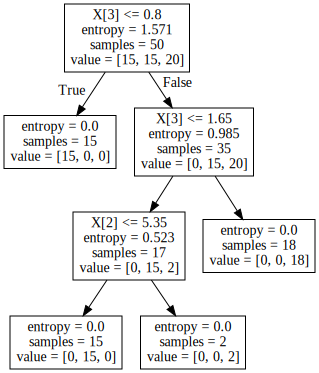

In [41]:
show_decision_tree(decision_tree)

In [42]:
print("Accuracy = %.3f" % (decision_tree.score(X, y)))

Accuracy = 1.000


No, decision trees are different from the one while using the whole dataset. First, the one for the whole dataset used "petal width (cm)" as the first criterion when the max_depth was 4, while the one for the train and test used "petal length (cm)" as the first criterion. Second, the accuracy value for the train and test was 1.000, which is simply due to overfitting as smaller sample ended up being more separable into the leaf nodes by decision tree than the whole dataset.

3. Plot how accuracy varies with increaing values of the `max_depth` parameter. 

In [43]:
from sklearn.datasets import load_iris

iris = load_iris()

X, y = iris.data, iris.target

In [44]:
d={}
for a in range(1,10): 
    decision_tree = DecisionTreeClassifier(max_depth=a, criterion="gini")
    decision_tree.fit(X, y)
    d[a]=decision_tree.score(X, y)


In [45]:
d

{1: 0.6666666666666666,
 2: 0.96,
 3: 0.9733333333333334,
 4: 0.9933333333333333,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0}

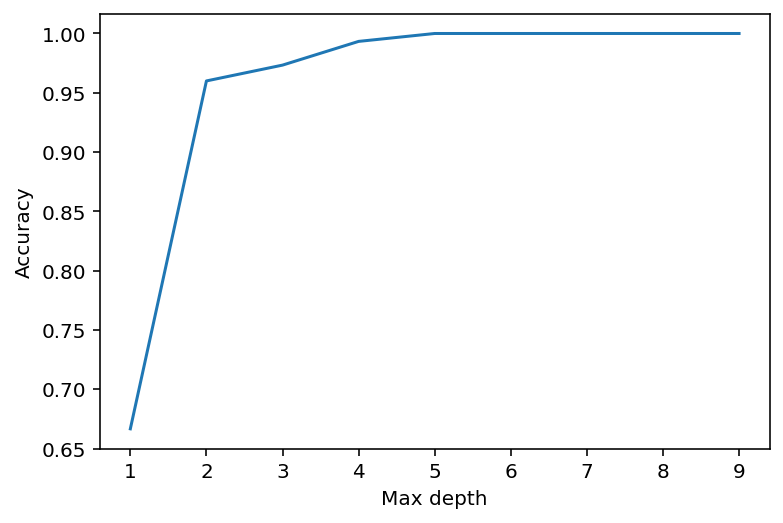

In [46]:
lists = sorted(d.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.show()


This is in line with the notion that if you set max_depth too high, then the decision tree might simply overfit the training data without capturing useful patterns as we would like; this will cause testing error to increase, but setting it too low is not good as well; then you might be giving the decision tree too little flexibility to capture the patterns and interactions in the training data.

4. Starting from the function `best_threshold`, create a function that returns the IG for different thredholds, not simply the best one. Plot IG vs the threshold. This is always a good practice to understand how good your best threshold is.

In [47]:
from sklearn.datasets import load_iris

iris = load_iris()

X, y = iris.data, iris.target

In [48]:
def thresholds(X, y):
    t={}
    for threshold in X:
        ig = information_gain(X, y, threshold)
        t[threshold]=ig

    return t

For sepal length (cm) : The maximum IG = 0.352 and it occured by splitting on 5.6000.


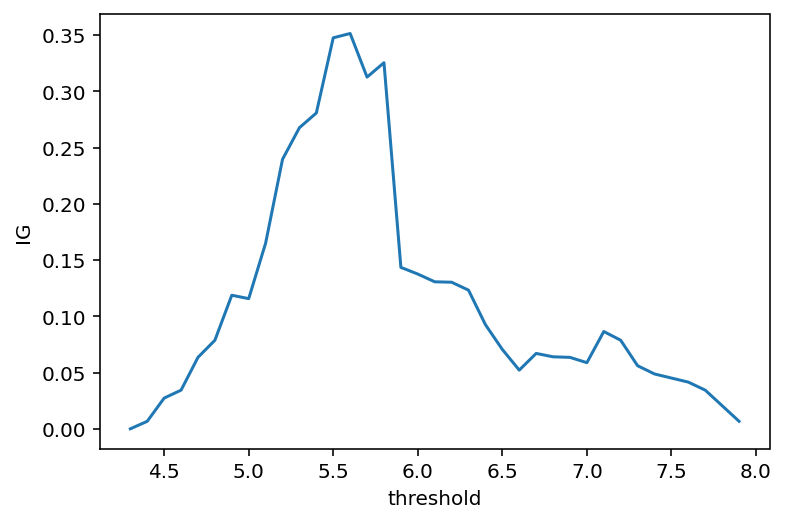

For sepal width (cm) : The maximum IG = 0.179 and it occured by splitting on 3.4000.


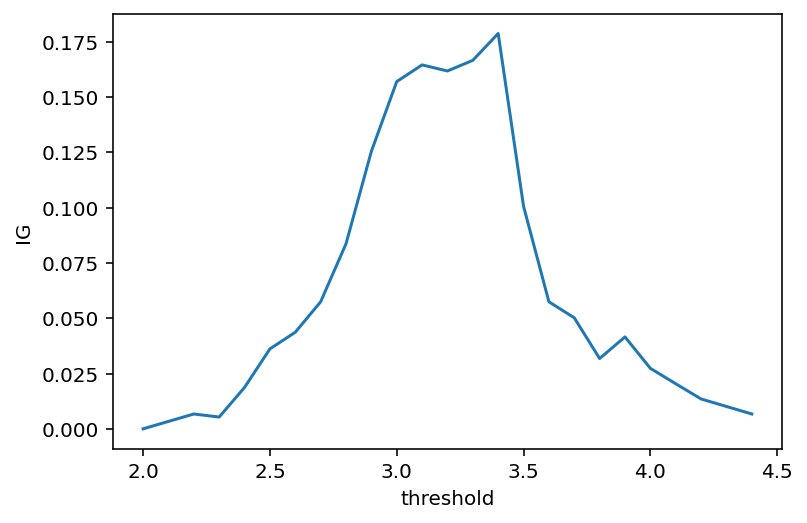

For petal length (cm) : The maximum IG = 0.520 and it occured by splitting on 1.9000.


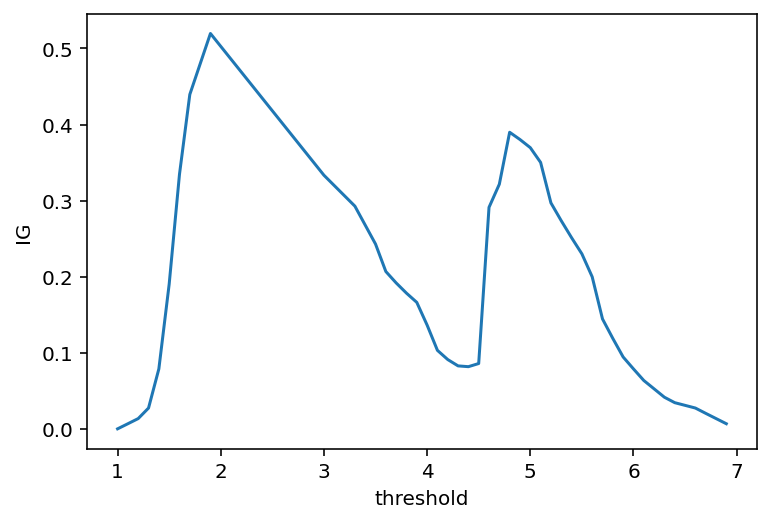

For petal width (cm) : The maximum IG = 0.545 and it occured by splitting on 0.6000.


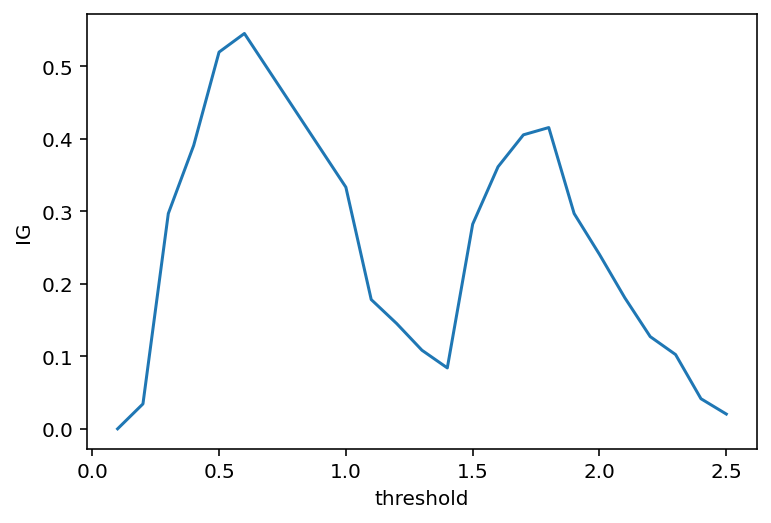

In [49]:
for a in range(0,4): 
    print("For", iris.feature_names[a],":", best_threshold(X[:, a], y))
    g=thresholds(X[:, a], y)
    lists = sorted(g.items()) # sorted by key, return a list of tuples
    xx, yy = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(xx, yy)
    plt.xlabel("threshold")
    plt.ylabel("IG")
    plt.show()


# Advanced (optional)


## Tips on pratical use

* Decision trees tend to overfit on data with a large number of features. Getting the right ratio of samples to number of features is important, since a tree with few samples in high dimensional space is very likely to overfit.

* Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.

* Visualise your tree as you are training by using the export function. Use *max\_depth=3* as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth.

* Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to. Use max_depth to control the size of the tree to prevent overfitting.

* Use min_samples_split or min_samples_leaf to control the number of samples at a leaf node. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try min_samples_leaf=5 as an initial value. If the sample size varies greatly, a float number can be used as percentage in these two parameters. The main difference between the two is that min_samples_leaf guarantees a minimum number of samples in a leaf, while min_samples_split can create arbitrary small leaves, though min_samples_split is more common in the literature.

* Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value. Also note that weight-based pre-pruning criteria, such as min_weight_fraction_leaf, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.

* If the samples are weighted, it will be easier to optimize the tree structure using weight-based pre-pruning criterion such as min_weight_fraction_leaf, which ensure that leaf nodes contain at least a fraction of the overall sum of the sample weights.

* All decision trees use np.float32 arrays internally. If training data is not in this format, a copy of the dataset will be made.

* If the input matrix X is very sparse, it is recommended to convert to sparse csc_matrix before calling fit and sparse csr_matrix before calling predict. Training time can be orders of magnitude faster for a sparse matrix input compared to a dense matrix when features have zero values in most of the samples.

## Plot the decision surface of a decision tree on the iris dataset

Plot the decision surface of a decision tree trained on pairs
of features of the iris dataset.

See `decision tree <tree>` for more information on the estimator.

For each pair of iris features, the decision tree learns decision
boundaries made of combinations of simple thresholding rules inferred from
the training samples.

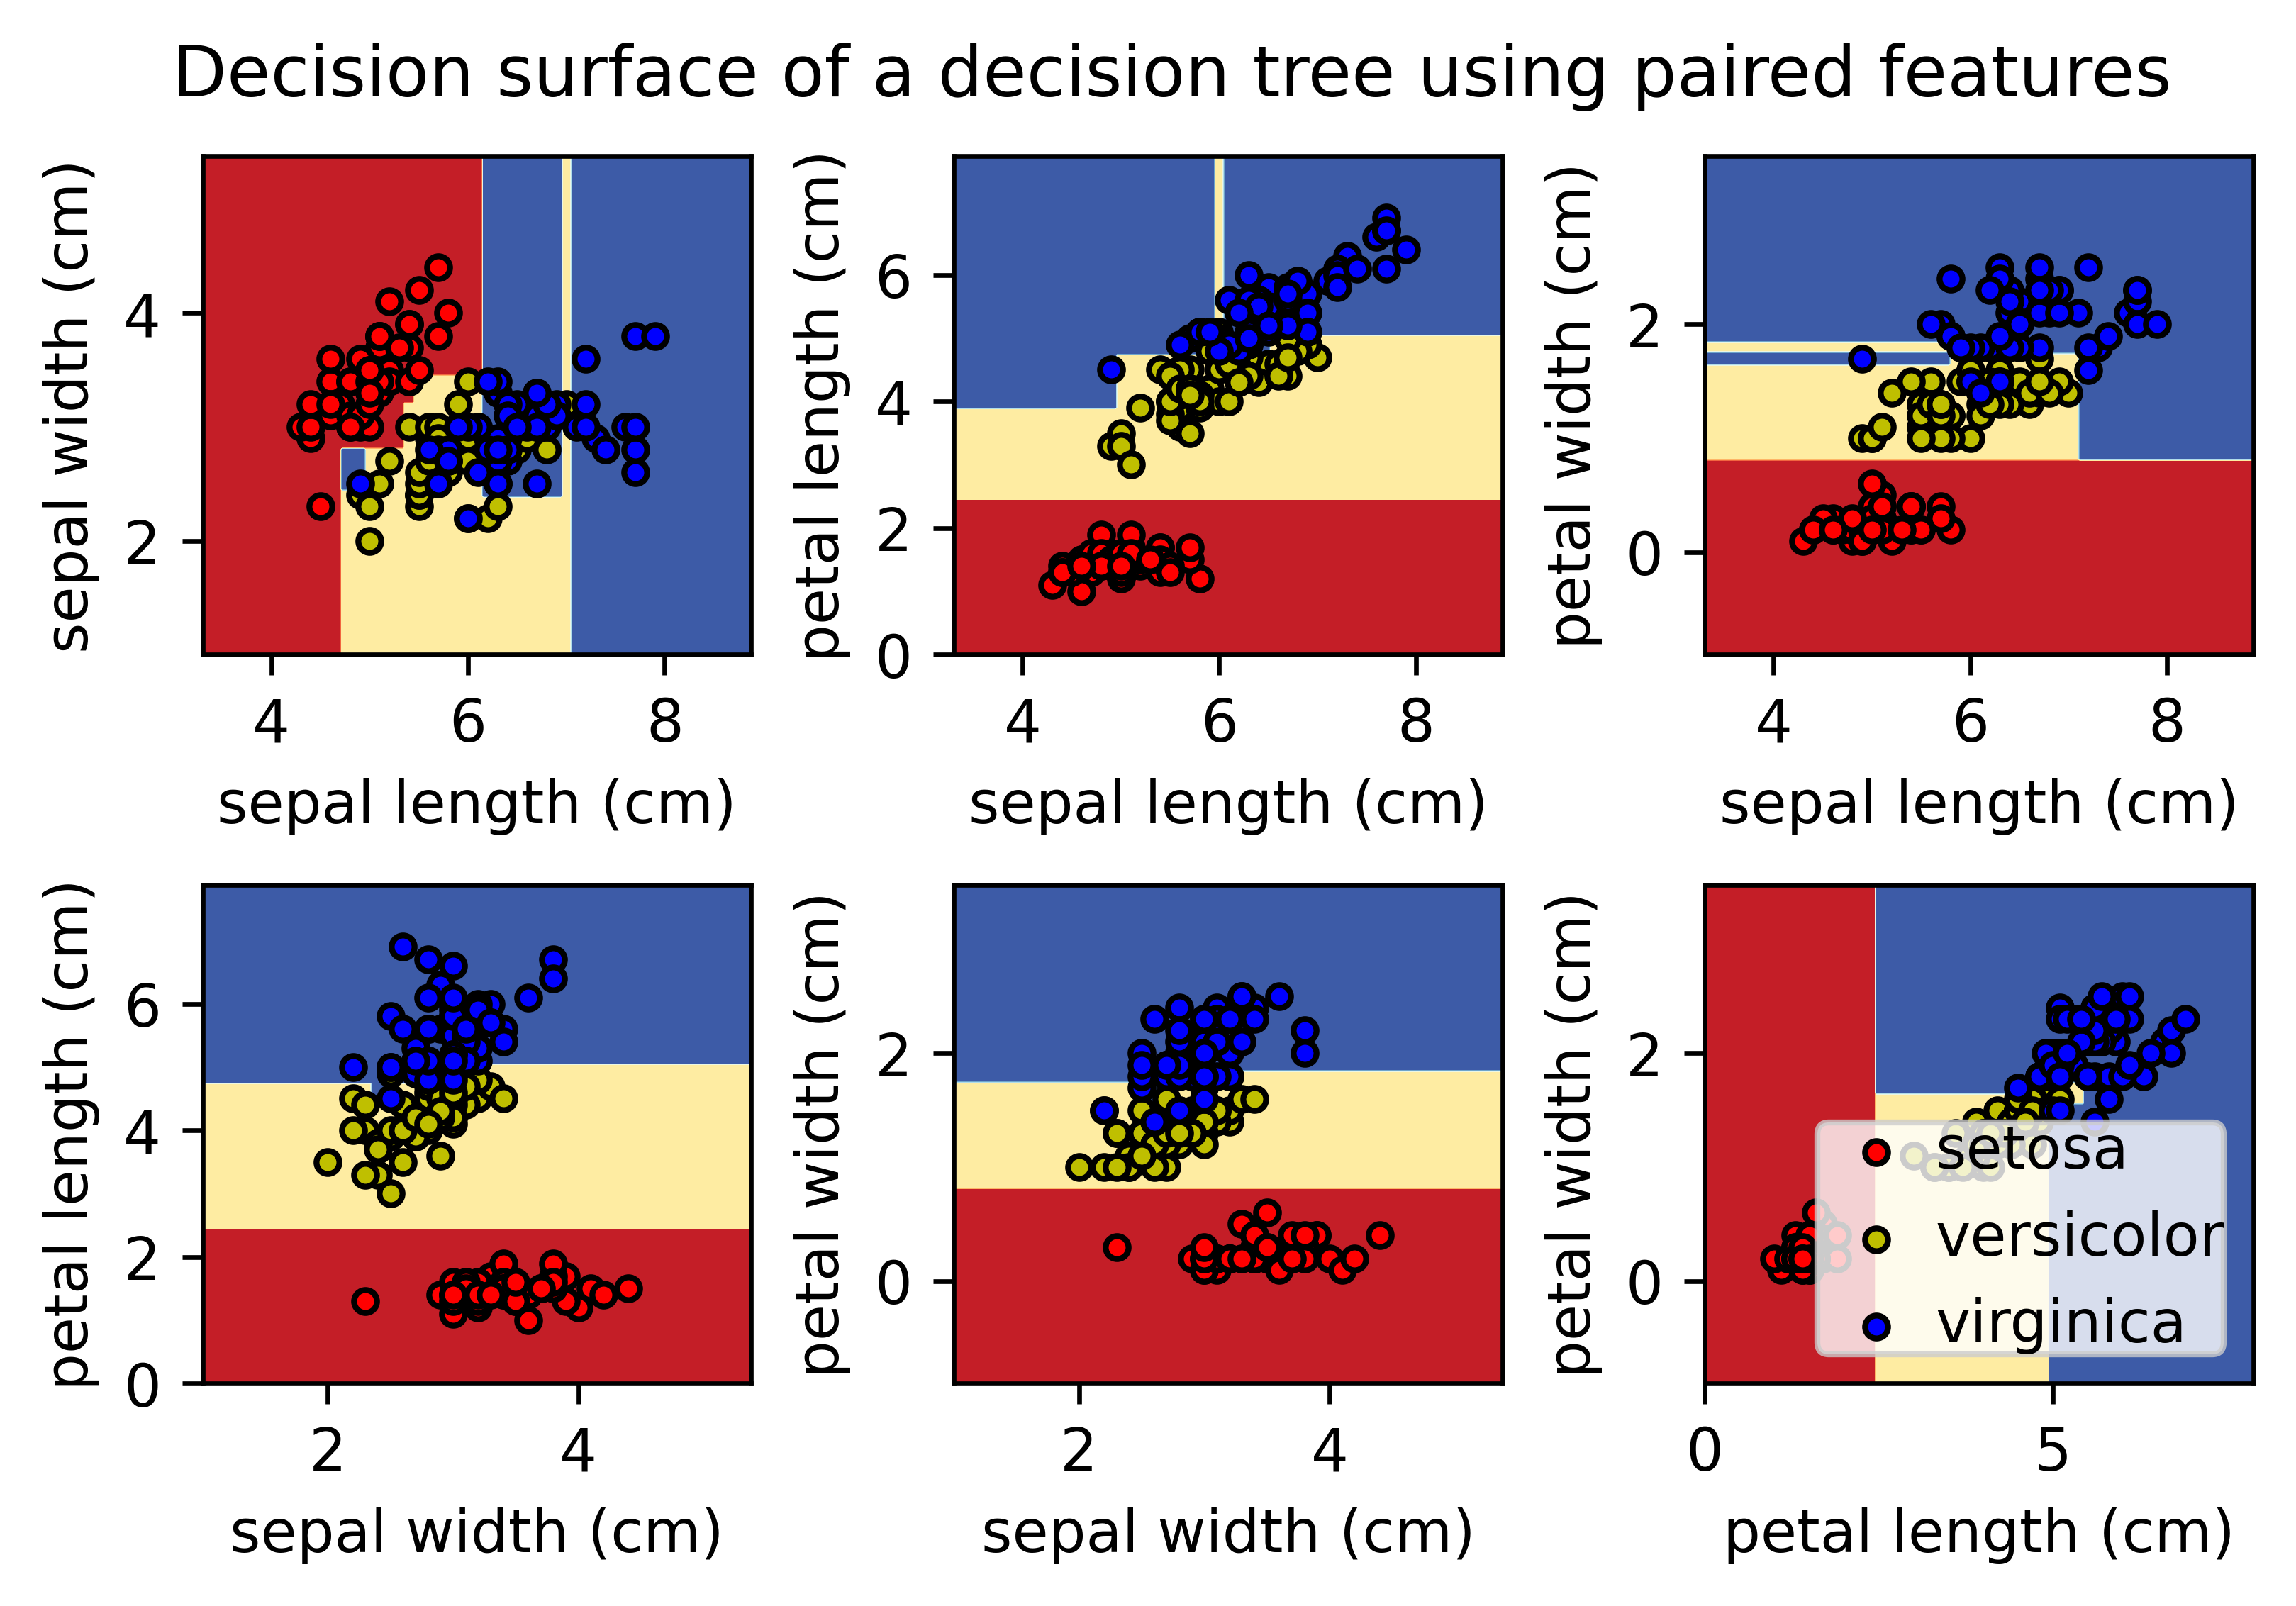

In [50]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

plt.rcParams['figure.dpi'] = 300


# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()